In [10]:
import os
import numpy as np
import networkx as nx
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
f = open("./users.csv", newline='', encoding="utf8")
reader = csv.reader(f)
lines = list(reader)
f.close()

user_id_to_info = {line[0] : line[1:] for line in lines[1:]}
user_ids = list(user_id_to_info)
user_info_header = lines[0][1:]

f = open("./tweets.csv", newline='', encoding="utf8")
reader = csv.reader(f)
lines = list(reader)
f.close()

user_id_to_tweets = {id: [] for id in user_ids}
tweet_id_to_author = {}
tweets = []
for line in lines[1:]:
    user_id_to_tweets[line[0]].append(line)
    tweets.append(line)
    if line[8] != '':
        tweet_id_to_author[line[8]] = line[0]
tweets_header = lines[0]

print(user_info_header)
print(tweets_header)


['location', 'name', 'followers_count', 'statuses_count', 'time_zone', 'verified', 'lang', 'screen_name', 'description', 'created_at', 'favourites_count', 'friends_count', 'listed_count']
['user_id', 'user_key', 'created_at', 'created_str', 'retweet_count', 'retweeted', 'favorite_count', 'text', 'tweet_id', 'source', 'hashtags', 'expanded_urls', 'posted', 'mentions', 'retweeted_status_id', 'in_reply_to_status_id']


In [12]:
num_users = len(user_ids)
retweet_matrix = np.zeros((num_users, num_users), dtype=np.int32)
num_all_retweets = 0
for tweet_id in tqdm(range(len(tweets))):
    tweet = tweets[tweet_id]
    author = tweet[0]
    retweeted_status_id = tweet[-2]
    if retweeted_status_id != '':
        num_all_retweets += 1
        if retweeted_status_id in tweet_id_to_author.keys():
            original_author = tweet_id_to_author[retweeted_status_id]
            retweet_matrix[user_ids.index(author), user_ids.index(original_author)] += 1

print(f"Share of inside retweets: {np.sum(retweet_matrix) / num_all_retweets}")
print(retweet_matrix)



100%|██████████| 203451/203451 [00:00<00:00, 665520.21it/s]

Share of inside retweets: 0.058816111377336125
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 5]]


In [13]:
print(num_users)
retweet_G = nx.from_numpy_array(retweet_matrix)
nx.write_gexf(retweet_G, "retweet_G.gexf")
alone_users = [d for d in retweet_G.nodes if retweet_G.degree[d] == 0]
num_alone_users = len(alone_users)
print(f"{num_alone_users} bots did not retweet any tweets from any bots from this group")

selfish_users = [d for d in retweet_G.nodes if len(retweet_G.edges(d)) == 1 and list(retweet_G.edges(d))[0][1] == d]
num_selfish_users = len(selfish_users)
print(f"{num_selfish_users} bots only retweeted their own tweets (among tweets from this group)")

main_users = list(set(range(num_users)) - set(selfish_users) - set(alone_users))
print(f"{len(main_users)} collaborated with at least one other bot")
main_retweet_G = retweet_G.subgraph(main_users)
nx.write_gexf(main_retweet_G, "main_retweet_G.gexf")

components = list(nx.connected_components(main_retweet_G))
print(f"Among them, {len(components)} connected components of sizes {[len(c) for c in components]}")
for i in range(len(components)):
    component_G = main_retweet_G.subgraph(components[i])
    nx.write_gexf(component_G, f"retweet_G_component_{i}.gexf")

G = main_retweet_G.subgraph(components[1])

print("Now, analysing the biggest component")



393
252 bots did not retweet any tweets from any bots from this group
3 bots only retweeted their own tweets (among tweets from this group)
138 collaborated with at least one other bot
Among them, 4 connected components of sizes [2, 131, 3, 2]
Now, analysing the biggest component


131


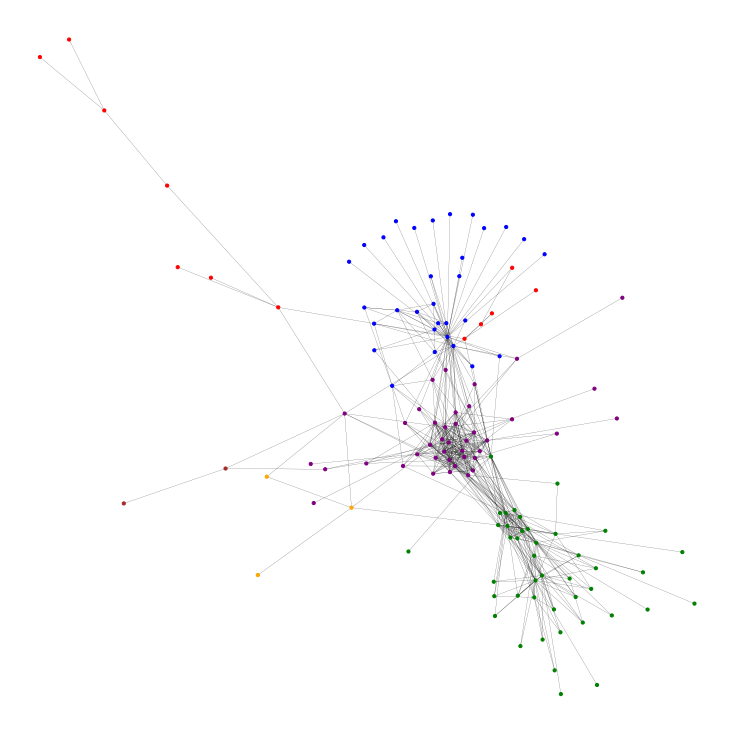

In [127]:
from networkx.algorithms import community

np.random.seed(42)

num_main_users = len(G.nodes)
print(num_main_users)
communities_generator = community.girvan_newman(G)
communities = list(next(communities_generator))
communities = list(next(communities_generator))
communities = list(next(communities_generator))
communities = list(next(communities_generator))
communities = list(next(communities_generator))

colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']
color_map = {node: 'black' for node in G.nodes}
user_to_community = {user: -1 for user in user_ids}

for c in range(len(communities)):
    community_users = communities[c]
    for user in community_users:
        color_map[user] = colors[c]
        user_to_community[user_ids[user]] = c


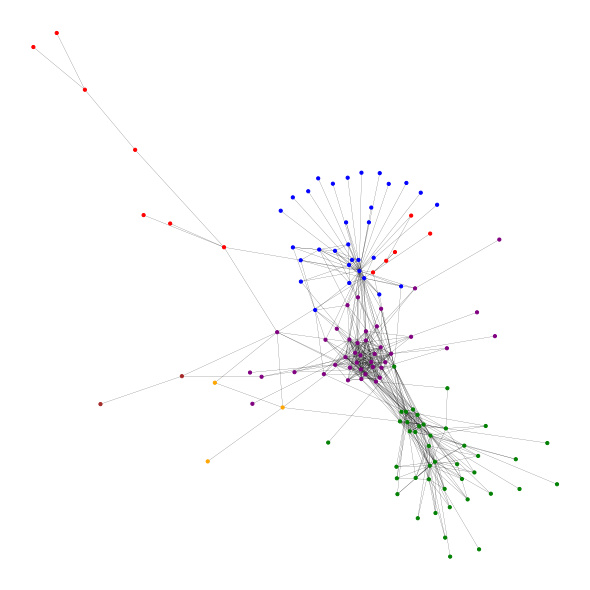

In [128]:
plt.figure(figsize=(8,8))
colors_list = list(color_map[node] for node in G.nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, node_color=colors_list, pos=pos, node_size=10, width=0.15)
plt.show()

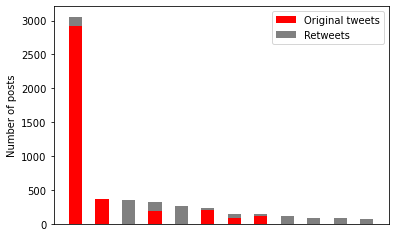

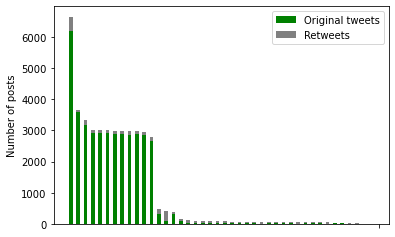

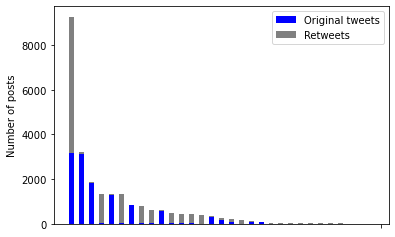

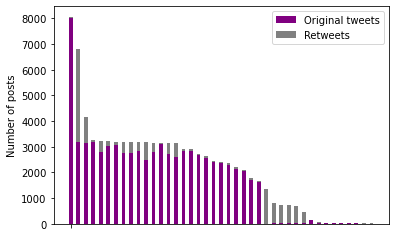

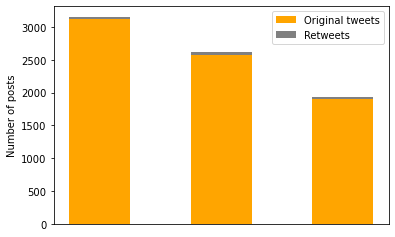

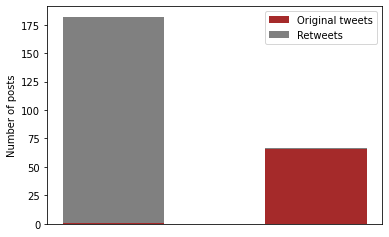

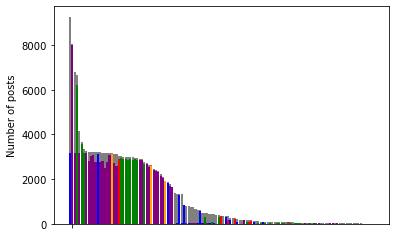

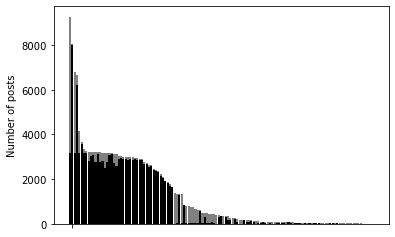

In [129]:
user_to_num_tweets = {user: len(ts) for user, ts in user_id_to_tweets.items()}
user_to_num_retweets = {user: len([t for t in ts if t[-2] != '']) for user, ts in user_id_to_tweets.items()}

for c in range(max(user_to_community.values()) + 1):
    community_users = [u for u, c2 in user_to_community.items() if c2 == c]
    community_users = sorted(community_users, key=lambda x: user_to_num_tweets[x], reverse=True)
    fig, ax = plt.subplots()
    plot_xs = community_users
    plot_ys2 = [user_to_num_retweets[u] for u in community_users]
    plot_ys1 = [user_to_num_tweets[u] - user_to_num_retweets[u] for u in community_users]
    ax.bar(plot_xs, plot_ys1, 0.5, label='Original tweets', color=colors[c])
    ax.bar(plot_xs, plot_ys2, 0.5, bottom=plot_ys1, label='Retweets', color='grey')

    ax.set_ylabel('Number of posts')
    # ax.set_title(f'Twitting strategy in group {c}')
    ax.set_xticks('')
    ax.legend()
    plt.show()

community_users = [u for u, c2 in user_to_community.items() if c2 != -1]
community_users = sorted(community_users, key=lambda x: user_to_num_tweets[x], reverse=True)
fig, ax = plt.subplots()
plot_xs = community_users
plot_ys2 = [user_to_num_retweets[u] for u in community_users]
plot_ys1 = [user_to_num_tweets[u] - user_to_num_retweets[u] for u in community_users]
ax.bar(plot_xs, plot_ys1, 0.9, color=[colors[user_to_community[x]] for x in plot_xs])
ax.bar(plot_xs, plot_ys2, 0.9, bottom=plot_ys1, color='grey')
ax.set_ylabel('Number of posts')
# ax.set_title(f'Twitting strategy in the whole connected component')
ax.set_xticks('')
plt.show()

fig, ax = plt.subplots()
ax.bar(plot_xs, plot_ys1, 0.9, color='black')
ax.bar(plot_xs, plot_ys2, 0.9, bottom=plot_ys1, color='grey')
ax.set_ylabel('Number of posts')
# ax.set_title(f'Twitting strategy in the whole connected component')
ax.set_xticks('')
plt.show()

Most popular hashtags:
[('"Politics"', 3606), ('"maga"', 3079), ('"Trump"', 2425), ('"tcot"', 2366), ('"news"', 1973), ('"NeverHillary"', 1375), ('"pjnet"', 1276), ('"TrumpPence16"', 980)]
Community -1
0.10127294256956779


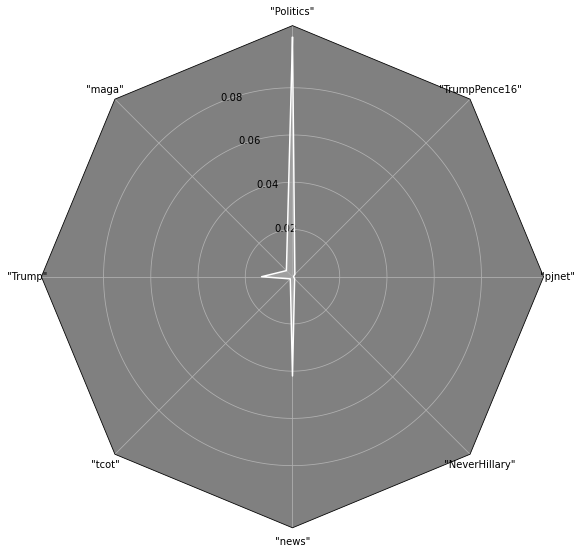

Community 0
0.011961268274159864


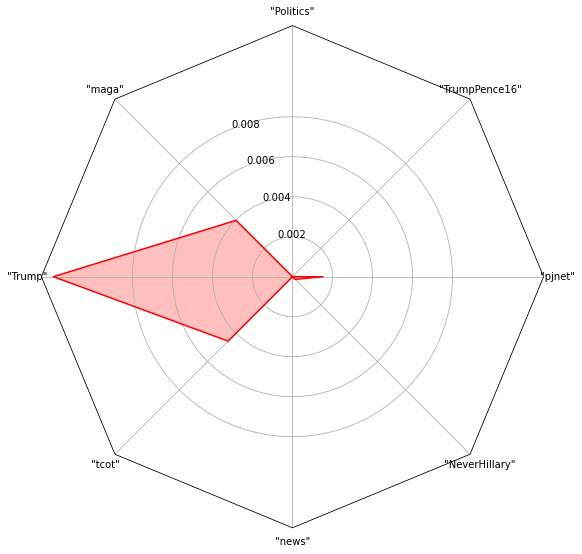

Community 1
0.0018940706349756312


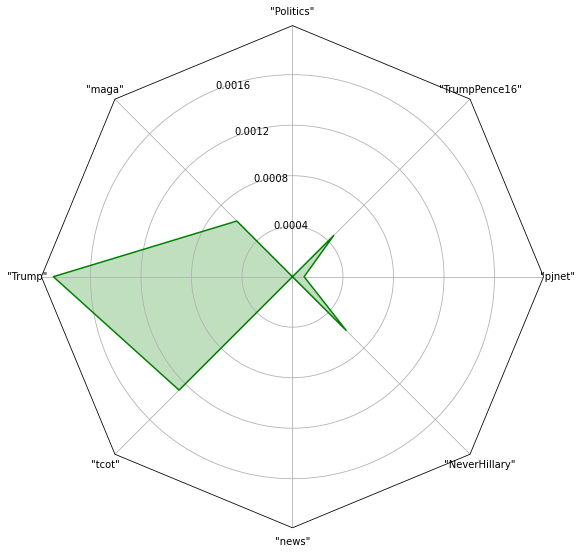

Community 2
0.05348903678902454


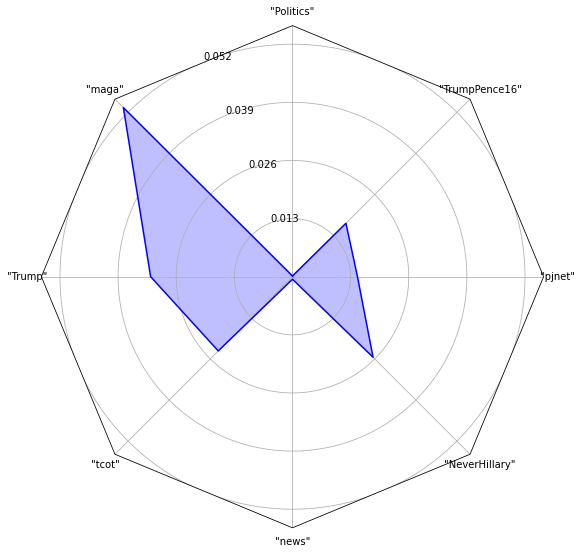

Community 3
0.018687056647607447


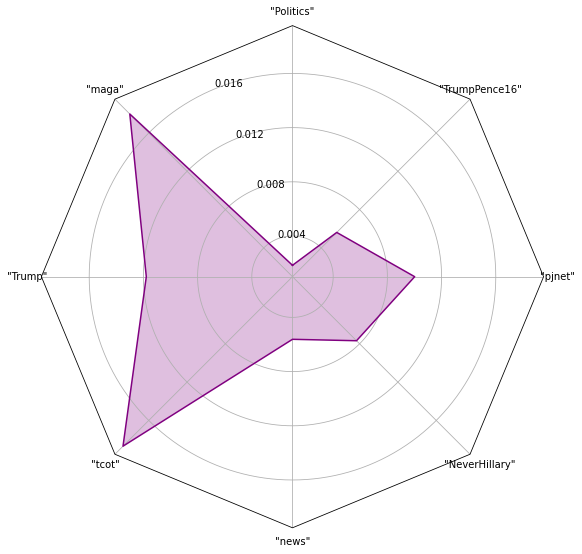

Community 4
0.005324675324675325


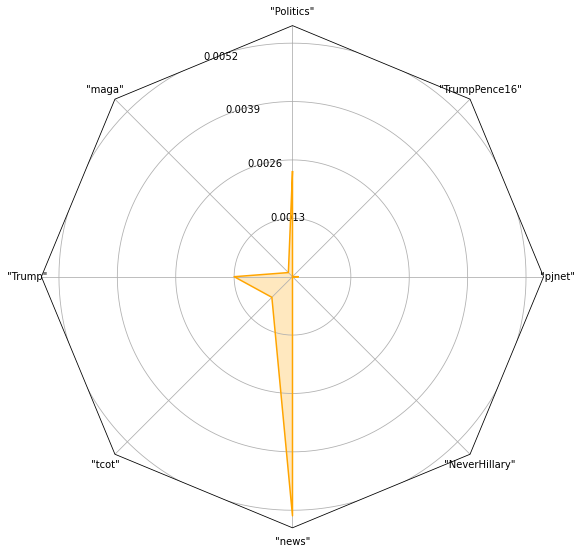

Community 5
0.024096385542168676


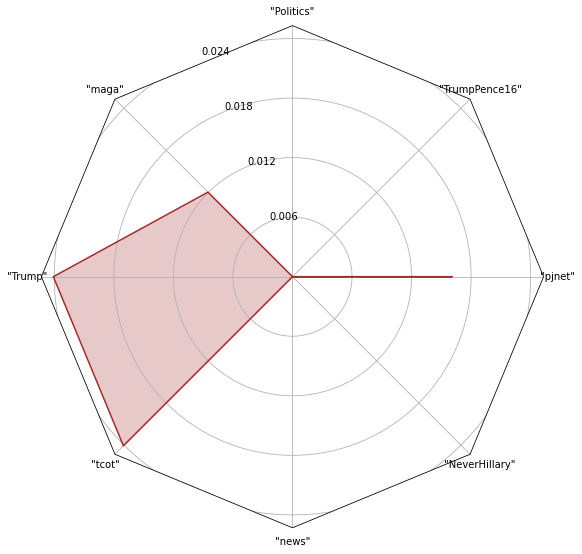

0.017724169456036096


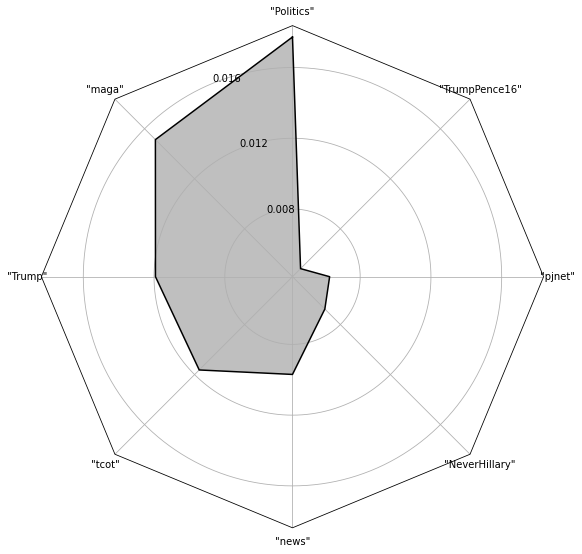

In [134]:
all_hashtags = [hashtag for tweet in tweets for hashtag in tweet[10][1:-1].split(",")]
unique_hashtags = set(all_hashtags)

user_to_hashtag_count = {user: {hashtag: 0 for hashtag in unique_hashtags} for user in user_ids}
for user in user_ids:
    user_tweets = user_id_to_tweets[user]
    for tweet in user_tweets:
        for hashtag in tweet[10][1:-1].split(","):
            user_to_hashtag_count[user][hashtag] += 1

hashtag_popularities = {hashtag: 0 for hashtag in unique_hashtags}
for h in all_hashtags:
    hashtag_popularities[h] += 1
hashtag_popularities = sorted(hashtag_popularities.items(), key=lambda x: x[1], reverse=True)
print("Most popular hashtags:")

most_popular_hashtags = [x[0] for x in hashtag_popularities[1:9]]
print(hashtag_popularities[1:9])


for c in range(-1, max(user_to_community.values()) + 1):
    most_popular_hashtags_popularity = {hashtag: 0 for hashtag in most_popular_hashtags}
    popularity_denominator = 0
    community_users = [u for u, c2 in user_to_community.items() if c2 == c]
    for community_user in community_users:
        for hashtag in most_popular_hashtags:
            most_popular_hashtags_popularity[hashtag] += user_to_hashtag_count[community_user][hashtag]
        popularity_denominator += user_to_num_tweets[community_user]
    print(f"Community {c}")
    vector = [most_popular_hashtags_popularity[h] / popularity_denominator for h in most_popular_hashtags]
    N = 8
    theta = radar_factory(N, frame='polygon')

    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    print(max(vector))
    if max(vector) < 0.01:
        y_resolution = (max(vector) / 4 // 0.0001 )* 0.0001
    elif max(vector) > 0.1:
        y_resolution = (max(vector) / 4 // 0.01 )* 0.01
    else:
        y_resolution = (max(vector) / 4 // 0.001 )* 0.001


    ax.set_rgrids([y_resolution, 2*y_resolution, 3*y_resolution, 4*y_resolution])
    if c==-1:
        ax.set_facecolor('grey')
        ax.plot(theta, vector, color='white')
        ax.fill(theta, vector, facecolor='white', alpha=0.25)
    else:
        ax.plot(theta, vector, color=colors[c])
        ax.fill(theta, vector, facecolor=colors[c], alpha=0.25)
    ax.set_varlabels(most_popular_hashtags)

    plt.show()

vector = [p[1] / len(tweets) for p in hashtag_popularities[1:9]]
theta = radar_factory(N, frame='polygon')
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
print(max(vector))
if max(vector) < 0.01:
    y_resolution = (max(vector) / 4 // 0.0001 )* 0.0001
elif max(vector) > 0.1:
    y_resolution = (max(vector) / 4 // 0.01 )* 0.01
else:
    y_resolution = (max(vector) / 4 // 0.001 )* 0.001

ax.set_rgrids([y_resolution, 2*y_resolution, 3*y_resolution, 4*y_resolution])
ax.plot(theta, vector, color='black')
ax.fill(theta, vector, facecolor='black', alpha=0.25)
ax.set_varlabels(most_popular_hashtags)

plt.show()

In [45]:
# DEFINITION OF RADAR PLOT

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta



100%|██████████| 203451/203451 [00:02<00:00, 89243.29it/s]


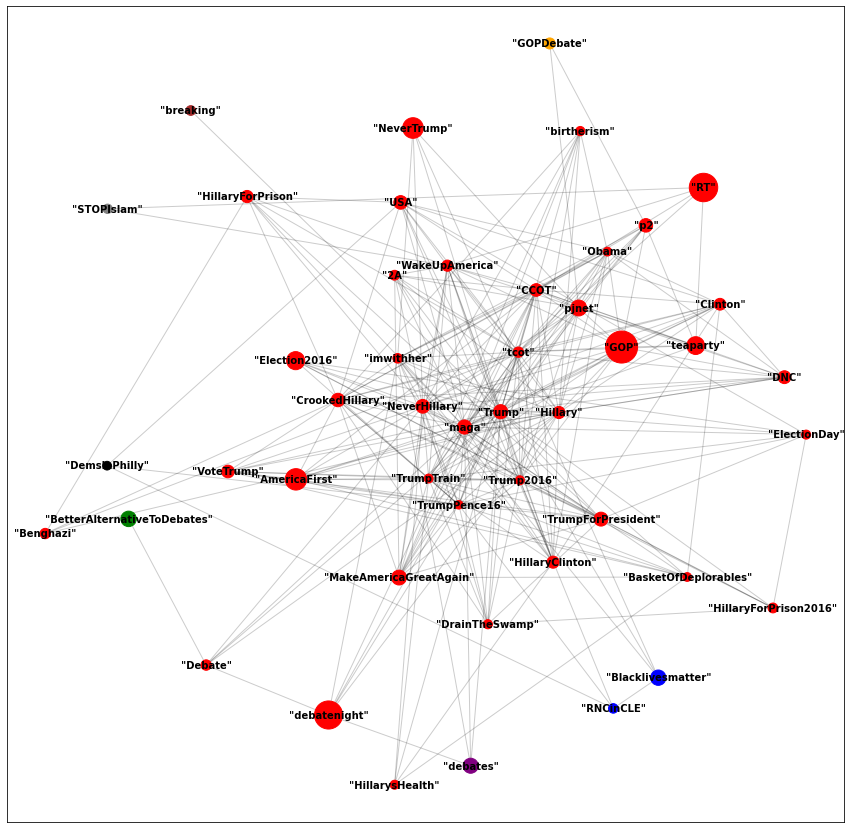

In [135]:
chosen_hashtags_list = [h[0] for h in hashtag_popularities[1:101]]
chosen_hashtags_popularities = [h[1] / 3 for h in hashtag_popularities[1:101]]
num_hashtags = len(chosen_hashtags_list)
hashtags_matrix_by_tweets = np.zeros((num_hashtags, num_hashtags), dtype=np.int32)
hashtag_to_index = {h: i for h, i in zip(chosen_hashtags_list, range(num_hashtags))}

for tweet_id in tqdm(range(len(tweets))):
    tweet = tweets[tweet_id]
    tweet_hashtags = tweet[10][1:-1].split(",")
    for h1 in tweet_hashtags:
        if h1 in chosen_hashtags_list:
            h1_index = hashtag_to_index[h1]
            for h2 in tweet_hashtags:
                if h2 in chosen_hashtags_list:
                    hashtags_matrix_by_tweets[h1_index, hashtag_to_index[h2]] += 1

hashtags_matrix_by_tweets[hashtags_matrix_by_tweets < 10] = 0
hashtags_by_tweets_G = nx.from_numpy_array(hashtags_matrix_by_tweets)
mapping = {i: chosen_hashtags_list[i] for i in range(num_hashtags)}
hashtags_by_tweets_G = nx.relabel_nodes(hashtags_by_tweets_G, mapping=mapping)
components = list(nx.connected_components(hashtags_by_tweets_G))
components = sorted(components, key=lambda x: len(x), reverse=True)
hashtags_by_tweets_G = hashtags_by_tweets_G.subgraph(components[0])
node_sizes = [chosen_hashtags_popularities[i] for i in range(num_hashtags) if chosen_hashtags_list[i] in components[0]]

communities_generator = community.girvan_newman(hashtags_by_tweets_G)
communities = list(next(communities_generator))
communities = list(next(communities_generator))
communities = list(next(communities_generator))
communities = list(next(communities_generator))
communities = list(next(communities_generator))
communities = list(next(communities_generator))
communities = list(next(communities_generator))

colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'grey', 'black']
color_map = {node: 'black' for node in hashtags_by_tweets_G.nodes}

for c in range(len(communities)):
    community_hashtags = communities[c]
    for h in community_hashtags:
        color_map[h] = colors[c]

colors_list = list(color_map[node] for node in hashtags_by_tweets_G.nodes)

plt.figure(figsize=(15,15))
np.random.seed(42)
pos = nx.spring_layout(hashtags_by_tweets_G, seed=42, k=4)
nx.draw_networkx_labels(hashtags_by_tweets_G, pos=pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(hashtags_by_tweets_G, pos=pos, alpha=0.2)
nx.draw_networkx_nodes(hashtags_by_tweets_G, pos=pos, node_size=node_sizes, node_color=colors_list)

plt.show()


100%|██████████| 203451/203451 [00:05<00:00, 40405.23it/s]


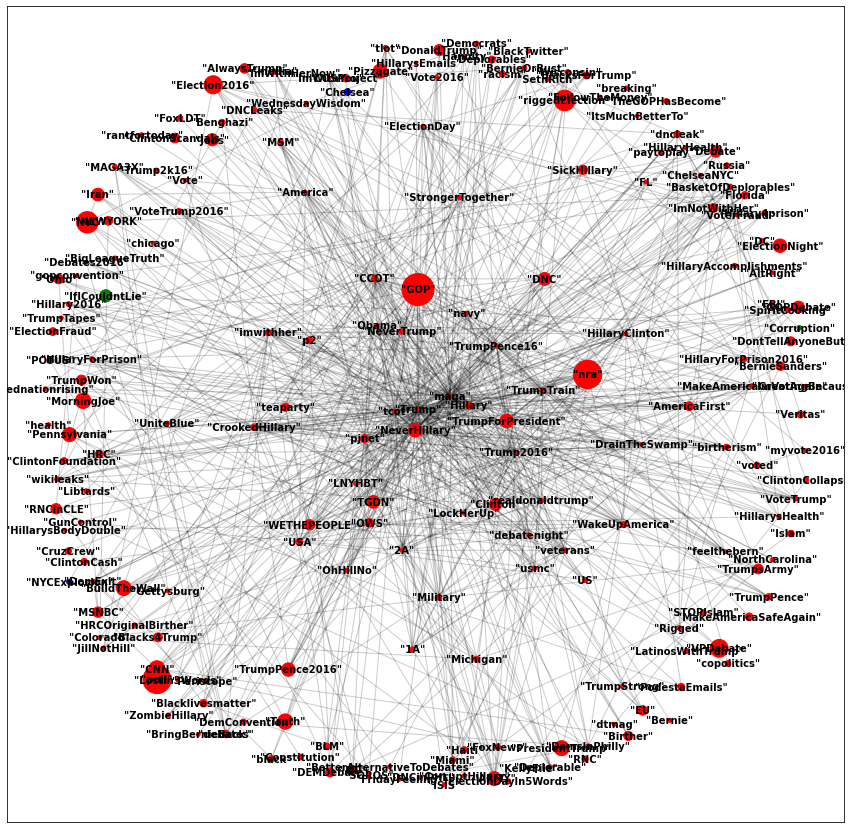

In [136]:
chosen_hashtags_list = [h[0] for h in hashtag_popularities[1:501]]
chosen_hashtags_popularities = [h[1] / 3 for h in hashtag_popularities[1:501]]
num_hashtags = len(chosen_hashtags_list)
hashtags_matrix_by_tweets = np.zeros((num_hashtags, num_hashtags), dtype=np.int32)
hashtag_to_index = {h: i for h, i in zip(chosen_hashtags_list, range(num_hashtags))}

for tweet_id in tqdm(range(len(tweets))):
    tweet = tweets[tweet_id]
    tweet_hashtags = tweet[10][1:-1].split(",")
    for h1 in tweet_hashtags:
        if h1 in chosen_hashtags_list:
            h1_index = hashtag_to_index[h1]
            for h2 in tweet_hashtags:
                if h2 in chosen_hashtags_list:
                    hashtags_matrix_by_tweets[h1_index, hashtag_to_index[h2]] += 1

hashtags_matrix_by_tweets[hashtags_matrix_by_tweets < 10] = 0
hashtags_by_tweets_G = nx.from_numpy_array(hashtags_matrix_by_tweets)
mapping = {i: chosen_hashtags_list[i] for i in range(num_hashtags)}
hashtags_by_tweets_G = nx.relabel_nodes(hashtags_by_tweets_G, mapping=mapping)
components = list(nx.connected_components(hashtags_by_tweets_G))
components = sorted(components, key=lambda x: len(x), reverse=True)
hashtags_by_tweets_G = hashtags_by_tweets_G.subgraph(components[0])
node_sizes = [chosen_hashtags_popularities[i] for i in range(num_hashtags) if chosen_hashtags_list[i] in components[0]]

communities_generator = community.girvan_newman(hashtags_by_tweets_G)
communities = list(next(communities_generator))
communities = list(next(communities_generator))

colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'grey', 'black']
color_map = {node: 'black' for node in hashtags_by_tweets_G.nodes}

for c in range(len(communities)):
    community_hashtags = communities[c]
    for h in community_hashtags:
        color_map[h] = colors[c]

colors_list = list(color_map[node] for node in hashtags_by_tweets_G.nodes)

plt.figure(figsize=(15,15))
np.random.seed(42)
pos = nx.spring_layout(hashtags_by_tweets_G, seed=42, k=4)
nx.draw_networkx_labels(hashtags_by_tweets_G, pos=pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(hashtags_by_tweets_G, pos=pos, alpha=0.2)
nx.draw_networkx_nodes(hashtags_by_tweets_G, pos=pos, node_size=node_sizes, node_color=colors_list)

plt.show()

In [139]:
query = '"Politics"'

num_never_trump_connections = {h: 0 for h in unique_hashtags}

for tweet in tweets:
    tweet_hashtags = tweet[10][1:-1].split(",")
    if query in tweet_hashtags:
        for h in tweet_hashtags:
            num_never_trump_connections[h] += 1

num_never_trump_connections = sorted(num_never_trump_connections.items(), key=lambda x: x[1], reverse=True)
print(f"Most often coocuring with {query}")
for i in range(1, 10):
    print(num_never_trump_connections[i])


Most often coocuring with "Politics"
('"Cleveland"', 145)
('"Trump"', 3)
('"NeverTrump"', 2)
('"feedly"', 2)
('"RNCinCLE"', 2)
('"Hillary"', 2)
('"Obama"', 2)
('"Corrupt"', 1)
('"FBI"', 1)


In [141]:
for tweet in tweets:
    tweet_hashtags = tweet[10][1:-1].split(",")
    if query in tweet_hashtags and '"Cleveland"' in tweet_hashtags:
        print(tweet[7])

Who could be on the stump for Hillary Clinton and Donald Trump in Ohio: Ohio Politics Roundup: Who's stumping fo...  #Cleveland #politics
Hillary Clinton responds to Donald Trump's criticism of Khizr and Ghazala Khan: Politics Extra: Trump says he is...  #Cleveland #politics
Melania Trump isn't the first to face political plagiarism accusations: Donald Trump's wife, Melania, whose Repu...  #Cleveland #politics
Donald Trump holds 'town hall' in Columbus (live coverage): https://t.co/f24oObBLAg reporter Jeremy Pelzer is cov...  #Cleveland #politics
Convention vendors peddle unconventional RNC merchandise (video): Convention vendors peddle elephant themed wine...  #Cleveland #politics
Montel Williams: 'Leave John Kasich alone' (video): Television talk-show host Montel Williams, an early supporte...  #Cleveland #politics
Donald Trump sees post-convention boost in new poll: Politics Extra: The FBI announced its investigation of the ...  #Cleveland #politics
Republicans give the Q a facelift